# Data Ingestion from BigQuery

<strong>Step 1: Exploratory Data Analysis</strong>

In [1]:
%%bigquery all_artists_df

SELECT artist_name,
       count(*) AS num_listens_per_artist
FROM   `listenbrainz.listenbrainz.listen`
GROUP  BY artist_name
ORDER  BY count(*) DESC; 

Query is running:   0%|          |

Downloading:   0%|          |

In [2]:
all_artists_df.head()

,artist_name,num_listens_per_artist
0,Radiohead,582658
1,The Beatles,559065
2,Pink Floyd,440631
3,Daft Punk,414091
4,Muse,335187


In [3]:
all_artists_df.shape

(1098460, 2)

<AxesSubplot:ylabel='Frequency'>

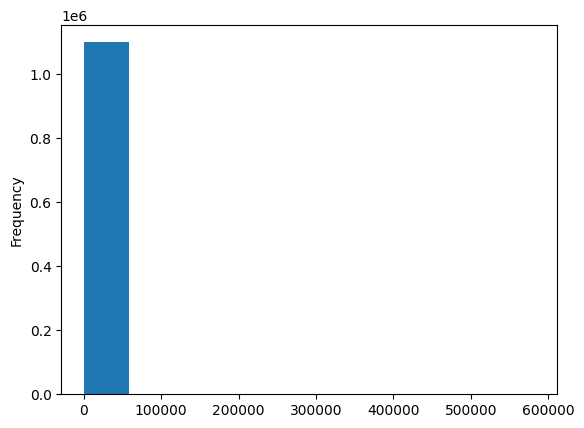

In [4]:
all_artists_df.num_listens_per_artist.plot(kind='hist')

In [5]:
all_artists_df.describe()

,num_listens_per_artist
count,1.098460e+06
mean,1.337457e+02
std,2.434018e+03
min,1.000000e+00
25%,1.000000e+00
50%,3.000000e+00
75%,1.200000e+01
max,5.826580e+05


In [6]:
all_artists_df[all_artists_df.num_listens_per_artist > 58000].shape

(288, 2)

<AxesSubplot:ylabel='Frequency'>

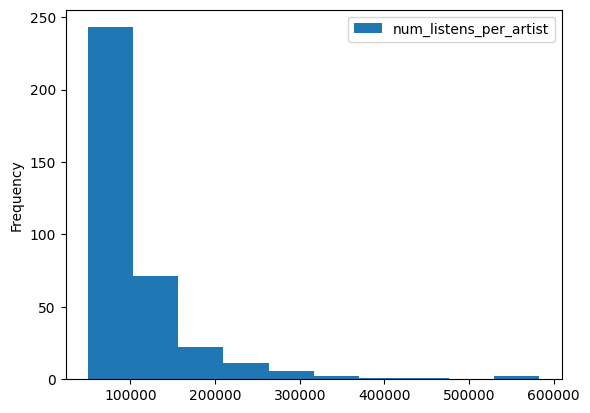

In [7]:
all_artists_df[all_artists_df.num_listens_per_artist > 50000].plot(kind='hist')

<strong>Step 2: Ingest Artists Data from Listen Brainz Dataset</strong>

This query gets a list of the top 300 most popular artists from the Listen Brainz data table, as determined by the number of user listen events.

In [8]:
%%bigquery artists_df

SELECT artist_name
FROM   `listenbrainz.listenbrainz.listen`
GROUP  BY artist_name
ORDER  BY count(*) DESC
LIMIT  300; 

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
artists_df.head(10).sort_values(by='artist_name')

,artist_name
6,Aphex Twin
7,Coldplay
3,Daft Punk
8,Metallica
4,Muse
5,Nine Inch Nails
2,Pink Floyd
9,Queen
0,Radiohead
1,The Beatles


<strong>Step 3: Ingest User Listening Data</strong>

This query gets a corresponding list of user listens for each artist in the top 300 list.

In [10]:
%%bigquery play_counts_df

SELECT user_name,
       artist_name,
       count(*) AS cnt
FROM   `listenbrainz.listenbrainz.listen`
WHERE  artist_name IN (SELECT artist_name
                       FROM   `listenbrainz.listenbrainz.listen`
                       GROUP  BY artist_name
                       ORDER  BY count(*) DESC
                       LIMIT  300)
GROUP  BY user_name,
          artist_name; 

Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
play_counts_df.head()

,user_name,artist_name,cnt
0,scaba,U2,516
1,eightiesSpandex,U2,1380
2,criscroc,U2,693
3,angelzoom,U2,77
4,reivering,U2,94


In [12]:
play_counts_df.isna().sum()

user_name      0
artist_name    0
cnt            0
dtype: int64

In [13]:
play_counts_df.shape

(251842, 3)

<strong>Step 3: Write the two ingested datasets out to static files in the working directory</strong>

The output files are in the 'feather' format, which is a portable file format for storing pandas dataframes. See [here](https://arrow.apache.org/docs/python/feather.html) for more details.

In [15]:
artists_df.to_feather("input_data/artist_df.feather")

In [16]:
play_counts_df.to_feather("input_data/play_counts_df.feather")